In [74]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
import wget
import dask
import os
from tqdm import tqdm
import glob
import os

from numpy import linalg as LA
import math
import sklearn.preprocessing
import bahc
import pyRMT

%matplotlib inline

## Download k-line spot data by every minute from binance

In [75]:
url_template = r"https://data.binance.vision/data/spot/daily/klines/{0}/1h/{0}-1h-{1}.zip"
dir_template = r"data/spot/daily/klines/{0}/1h/{0}-1h-{1}.zip"


# @dask.delayed
def download_one_date(url, path):
    try:
        tmp = wget.download(url, out=path)
        return True
    except:
        # print("{} download failed".format(url))
        return False

def download_all_dates(token_pair: str, dates, path):
    first_meet = False
    for each in dates:
        res = download_one_date(url_template.format(token_pair, str(each.date())), path)
        if first_meet == False and res == True:
            first_meet = True
        if first_meet == True and res == False:
            break
    # promises = [download_one_date(url_template.format(token_pair, str(each.date())), path) for each in dates]
    # alldata=dask.compute(promises) 
    
def get_asset_pairs(x):
    with open("asset_pairs.txt", "r") as f:
        names = f.read()
    names = names.replace("\t", "")
    names = names.replace("\n", "")
    names = names.split("/")
    x_names = list(filter(lambda each: each.endswith(x), names))
    print("x: {} results length: {}".format(x, len(x_names)))
    return x_names

@dask.delayed
def main_download(pair, dates):
    path = "data/spot/daily/klines/{0}/1h".format(pair)
    if not os.path.exists(path):
        os.makedirs(path)
    download_all_dates(pair, dates, path)
    

In [76]:
USDT_pairs = get_asset_pairs("USDT")
BUSD_pairs = get_asset_pairs("BUSD")

x: USDT results length: 394
x: BUSD results length: 350


In [5]:
USDT_pairs = ["BTCUSDT"]
dates = pd.date_range(start="2021-03-01",end="2023-01-15")
promises = [main_download(each, dates) for each in USDT_pairs]
dask.compute(promises)
# for i in tqdm(range(len(USDT_pairs))):
#     main_download(USDT_pairs[i], dates)

([None],)

In [45]:
dates = pd.date_range(start="2021-03-01",end="2023-01-15")
print(len(list(dates)))

686


In [46]:
686*24

16464

## Data loading & pre-processing

In [77]:
@dask.delayed
def process_raw(pair, path):
    names = [
        "Open time",
        "Open",
        "High",
        "Low",
        "Close",
        "Volume",
        "Close time",
        "Quote asset volume",
        "Number of trades",
        "Taker buy base asset volume",
        "Taker buy quote asset volume",
        "Ignore",
    ]
    asset_data = pd.read_csv(path, names=names, header=None)
    # btcdata = pd.read_csv(dir_template.format(pair, date), names=names, header=None)
    asset_data["time"] = pd.to_datetime(asset_data["Open time"], unit='ms')
    asset_data[pair] = asset_data["Close"]
    date_indexed = asset_data.set_index("time")
    date_indexed.drop([
        "Open time",
        "Open",
        "High",
        "Low",
        "Close",
        "Volume",
        "Close time",
        "Quote asset volume",
        "Number of trades",
        "Taker buy base asset volume",
        "Taker buy quote asset volume",
        "Ignore",
        ], axis=1, inplace=True)
    # date_indexed.drop('Close time', axis=1, inplace=True)
    
    # date_indexed.drop('time', axis=1, inplace=True)

    # date_indexed["s"] = (date_indexed["isBuyerMaker"].astype(int)-0.5)*(-2)
    # date_indexed["mid"] = date_indexed["price"]
    return date_indexed


def load_one_pair(pair):
    files = glob.glob("data/spot/daily/klines/{}/1h/*".format(pair))
    files = [each for each in files if "(" not in each]
    if len(files) == 0:
        print(f"{pair} is empty, no files found")
        return False, None
    tasks = [process_raw(pair, each) for each in files]
    p_data_arr = dask.compute(tasks)
    result = pd.concat(p_data_arr[0])
    return True, result

def merge_assets(pd_arr, col: str):
    assets_close_matrix = pd_arr[0]
    for each in pd_arr[1:]:
        assets_close_matrix = assets_close_matrix.merge(each, how="outer", on=col)
        # assets_close_matrix = assets_close_matrix.join(each)
        # print(assets_close_matrix.shape)
        if assets_close_matrix.shape[0] > 16464:
            print(f"{each.columns} wrong rows: {assets_close_matrix.shape[0]}")
            assert True==False
    return assets_close_matrix

In [13]:
def main_load_and_merge_all_assets():
    existing_pairs = os.listdir("data/spot/daily/klines")
    print("Number of pairs: ", len(existing_pairs))
    chunk_sz = 10
    subsets = [existing_pairs[i:i + chunk_sz] for i in range(0, len(existing_pairs), chunk_sz)]
    # print(sum([len(each) for each in subsets]))
    for i in tqdm(range(len(subsets))):
        chunk = subsets[i]
        tmp_assets_arr = list()
        for each in chunk:
            success, tmp_asset = load_one_pair(each)
            if success:
                if tmp_asset.shape[0] > 16464:
                    print(f"{each} wrong rows: {tmp_asset.shape[0]}")
                tmp_assets_arr.append(tmp_asset)
        # tmp_assets_arr = [load_one_pair(each) for each in chunk]
        tmp_merge_result = merge_assets(tmp_assets_arr, "time")
        tmp_merge_result.to_pickle(f"data/clean/mk_{i}.pkl")
        
    
def inspect_assets_shape():
    existing_pairs = os.listdir("data/spot/daily/klines")
    print("Number of pairs: ", len(existing_pairs))
    # assets_pd_arr = [load_one_pair(each) for each in existing_pairs]
    for pair in existing_pairs:
        success, tmp_asset = load_one_pair(pair)
        assert tmp_asset.shape[0] <= 16464, f"{pair} wrong rows: {tmp_asset.shape[0]}"

res = main_load_and_merge_all_assets()
# inspect_assets_shape()

  0%|          | 0/40 [00:00<?, ?it/s]

Number of pairs:  394


 38%|███▊      | 15/40 [17:17<38:00, 91.22s/it]

GALUSDT is empty, no files found


100%|██████████| 40/40 [43:10<00:00, 64.77s/it]


In [8]:
def merge_all_chunks(arr_id):
    df_arr = [pd.read_pickle(f"data/clean/mk_{i}.pkl") for i in arr_id]
    # for each in df_arr:
    #     print(each.shape)
    res = merge_assets(df_arr, "time")
    return res

In [14]:
res = merge_all_chunks([i for i in range(40)])
res.to_pickle("data/clean/whole_usdt_merge.pkl")
print(res.shape)

## MVP functions

In [78]:
def eigenvalue_clipping(lambdas,v,lambda_plus):
    N=len(lambdas)
    
    # _s stands for _structure below
    sum_lambdas_gt_lambda_plus=np.sum(lambdas[lambdas>lambda_plus])
    
    sel_bulk=lambdas<=lambda_plus                     # these eigenvalues come from the seemingly random bulk
    N_bulk=np.sum(sel_bulk)
    sum_lambda_bulk=np.sum(lambdas[sel_bulk])        
    delta=sum_lambda_bulk/N_bulk                      # delta is their average, so as to conserver the trace of C
    
    lambdas_clean=lambdas
    lambdas_clean[lambdas_clean<=lambda_plus]=delta
    
    
    C_clean=np.zeros((N, N))
    v_m=np.matrix(v)
    
    for i in range(N-1):
        C_clean=C_clean+lambdas_clean[i] * np.dot(v_m[i,].T,v_m[i,]) 
        
    np.fill_diagonal(C_clean,1)
            
    return C_clean    


def solution_eig(C_asset):
    # C_corr = C_asset.corr()
    C_cov = C_asset.cov()
    l_e, V_e = LA.eig(C_cov)
    T, N = C_asset.shape
    q = N/T
    lambda_plus = (1+np.sqrt(q))**2
    
    C_clipped=eigenvalue_clipping(l_e,V_e,lambda_plus)
    return C_clipped

def weights_GVM(Sigma):
    Sigma_inv=LA.inv(Sigma)
    w_GVM=Sigma_inv.sum(axis=1)/Sigma_inv.sum()
    return w_GVM
    

## Data preprocessing

In [79]:
all_data = pd.read_pickle("data/clean/whole_usdt_merge.pkl")
all_data = all_data.reset_index()
# all_data = all_data.drop(["time"], axis=1)

In [80]:
all_data

,time,1INCHDOWNUSDT,1INCHUPUSDT,1INCHUSDT,AAVEDOWNUSDT,AAVEUPUSDT,AAVEUSDT,ACAUSDT,ACHUSDT,ACMUSDT,...,XVSUSDT,YFIDOWNUSDT,YFIIUSDT,YFIUPUSDT,YFIUSDT,YGGUSDT,ZECUSDT,ZENUSDT,ZILUSDT,ZRXUSDT
0,2021-04-15 07:00:00,10.07,9.87,5.8799,1.327380,110.463,438.825,NaN,NaN,12.062,...,85.699,0.001495,3044.99,8.890,50826.78,NaN,246.49,96.655,0.20656,2.1644
1,2021-04-15 08:00:00,10.21,9.73,5.8589,1.367000,108.459,434.066,NaN,NaN,11.980,...,84.578,0.001558,2989.17,8.530,50035.84,NaN,247.08,97.583,0.20509,2.1828
2,2021-04-15 09:00:00,9.92,10.00,5.9137,1.320024,111.310,439.611,NaN,NaN,12.067,...,83.166,0.001554,3000.41,8.550,50046.70,NaN,248.45,97.487,0.20619,2.1800
3,2021-04-15 10:00:00,9.97,9.93,5.9084,1.301529,112.411,443.585,NaN,NaN,12.025,...,81.401,0.001595,2954.89,8.301,49476.40,NaN,244.61,95.743,0.20330,2.1540
4,2021-04-15 11:00:00,9.10,10.63,6.1123,1.232953,117.000,452.599,NaN,NaN,11.988,...,82.750,0.001548,3000.85,8.642,50269.64,NaN,246.76,97.111,0.20582,2.1780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16447,2023-01-15 19:00:00,NaN,NaN,NaN,NaN,NaN,80.100,0.1340,0.00926,2.947,...,5.030,NaN,1355.00,NaN,7092.00,0.2532,45.30,10.480,0.02575,0.2025
16448,2023-01-15 20:00:00,NaN,NaN,NaN,NaN,NaN,79.900,0.1324,0.00926,2.994,...,5.100,NaN,1357.30,NaN,7106.00,0.2592,45.40,10.470,0.02584,0.2033
16449,2023-01-15 21:00:00,NaN,NaN,NaN,NaN,NaN,79.700,0.1315,0.00920,3.115,...,5.050,NaN,1357.10,NaN,7068.00,0.2581,45.30,10.480,0.02579,0.2037
16450,2023-01-15 22:00:00,NaN,NaN,NaN,NaN,NaN,79.900,0.1312,0.00914,3.090,...,5.050,NaN,1352.20,NaN,7086.00,0.2573,45.20,10.530,0.02595,0.2037


In [81]:
log_ret_all_data = np.log(all_data).diff()

TypeError: ufunc 'log' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [82]:
log_ret_all_data

,1INCHDOWNUSDT,1INCHUPUSDT,1INCHUSDT,AAVEDOWNUSDT,AAVEUPUSDT,AAVEUSDT,ACAUSDT,ACHUSDT,ACMUSDT,ADADOWNUSDT,...,XVSUSDT,YFIDOWNUSDT,YFIIUSDT,YFIUPUSDT,YFIUSDT,YGGUSDT,ZECUSDT,ZENUSDT,ZILUSDT,ZRXUSDT
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.013807,-0.014286,-0.003578,0.029411,-0.018308,-0.010904,NaN,NaN,-0.006821,-0.008822,...,-0.013167,0.041277,-0.018502,-0.041338,-0.015684,NaN,0.002391,0.009555,-0.007142,0.008465
2,-0.028815,0.027371,0.009310,-0.034969,0.025947,0.012694,NaN,NaN,0.007236,-0.047252,...,-0.016836,-0.002571,0.003753,0.002342,0.000217,NaN,0.005529,-0.000984,0.005349,-0.001284
3,0.005028,-0.007025,-0.000897,-0.014110,0.009843,0.008999,NaN,NaN,-0.003487,0.052113,...,-0.021451,0.026041,-0.015288,-0.029555,-0.011461,NaN,-0.015577,-0.018052,-0.014115,-0.011998
4,-0.091306,0.068120,0.033928,-0.054128,0.040012,0.020117,NaN,NaN,-0.003082,-0.007548,...,0.016436,-0.029910,0.015434,0.040258,0.015906,NaN,0.008751,0.014187,0.012319,0.011080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16447,NaN,NaN,NaN,NaN,NaN,-0.014870,0.016554,-0.002157,0.041218,0.004934,...,0.001990,NaN,0.001182,NaN,0.008070,-0.010998,0.002210,-0.011385,-0.002715,-0.002466
16448,NaN,NaN,NaN,NaN,NaN,-0.002500,-0.012012,0.000000,0.015823,-0.008237,...,0.013821,NaN,0.001696,NaN,0.001972,0.023420,0.002205,-0.000955,0.003489,0.003943
16449,NaN,NaN,NaN,NaN,NaN,-0.002506,-0.006821,-0.006501,0.039619,0.005225,...,-0.009852,NaN,-0.000147,NaN,-0.005362,-0.004253,-0.002205,0.000955,-0.001937,0.001966
16450,NaN,NaN,NaN,NaN,NaN,0.002506,-0.002284,-0.006543,-0.008058,-0.010754,...,0.000000,NaN,-0.003617,NaN,0.002543,-0.003104,-0.002210,0.004760,0.006185,0.000000


In [83]:
t0 = 8000
t1 = 16000
X_raw = log_ret_all_data.iloc[t0:t1].dropna(axis=1)
X_raw.shape

(8000, 253)

In [84]:
X_raw

,AAVEUSDT,ACAUSDT,ACHUSDT,ACMUSDT,ADADOWNUSDT,ADAUPUSDT,ADAUSDT,ADXUSDT,AIONUSDT,AKROUSDT,...,XTZUSDT,XVGUSDT,XVSUSDT,YFIIUSDT,YFIUSDT,YGGUSDT,ZECUSDT,ZENUSDT,ZILUSDT,ZRXUSDT
8000,0.016944,0.037596,0.010463,0.008332,-0.015881,0.018140,0.009597,0.009128,0.010351,0.020501,...,0.010782,0.013205,0.011891,0.012456,0.015505,0.017925,0.013363,0.009248,0.014115,0.018657
8001,0.002685,0.008717,0.009066,-0.013926,-0.001256,0.002657,0.000000,0.000491,0.003427,0.012102,...,0.012323,-0.003032,-0.008309,0.010992,0.003121,0.012562,0.001106,0.002102,0.005104,0.004242
8002,-0.010782,-0.020038,-0.002582,-0.001531,0.004077,-0.007145,-0.002869,0.000736,-0.002283,0.000802,...,-0.010649,-0.005074,-0.002387,0.010439,-0.006650,-0.015984,-0.004430,-0.003155,-0.004214,-0.002765
8003,0.009440,0.023133,0.003613,0.001786,-0.008329,0.011086,0.003824,0.006844,0.002283,0.013530,...,0.012303,0.003047,0.005956,0.013752,0.004078,0.011588,0.012135,0.025219,0.006646,0.004604
8004,0.004019,-0.003095,0.005395,0.000000,-0.003794,0.002833,0.001907,0.003647,0.003415,0.014129,...,0.004287,0.005058,0.004739,0.033574,0.020826,0.004396,0.014154,0.020079,0.003086,0.009690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0.005231,-0.000821,0.002488,0.004274,0.001206,0.004728,0.000384,0.000000,0.002977,-0.012012,...,0.003889,0.000000,0.000000,-0.001065,0.004000,0.004185,0.002581,0.005479,0.005821,0.010609
15996,-0.008734,-0.002468,-0.002488,-0.003417,0.007924,-0.014252,-0.004621,-0.001693,-0.005216,0.023882,...,-0.003889,-0.007092,-0.002621,-0.002545,-0.004729,-0.005384,-0.002581,0.002183,-0.005237,-0.003108
15997,-0.003515,-0.004127,-0.006246,-0.001713,0.004891,0.000000,-0.004255,0.000000,0.008555,-0.008889,...,-0.005208,0.007092,0.000000,0.000329,-0.002190,-0.010250,0.000000,-0.004372,-0.003507,0.001245
15998,-0.005296,-0.004144,0.013690,0.002996,0.004749,-0.014458,-0.003106,0.001693,-0.000741,0.005935,...,-0.006549,0.003527,0.005236,0.000821,-0.001280,-0.003643,-0.002587,-0.009907,-0.006461,0.000622


In [42]:
X_raw.iloc[1000:2000]

,AAVEUSDT,ACAUSDT,ACHUSDT,ACMUSDT,ADADOWNUSDT,ADAUPUSDT,ADAUSDT,ADXUSDT,AIONUSDT,AKROUSDT,...,XTZUSDT,XVGUSDT,XVSUSDT,YFIIUSDT,YFIUSDT,YGGUSDT,ZECUSDT,ZENUSDT,ZILUSDT,ZRXUSDT
9000,0.001667,0.002784,0.000245,0.000000,-0.002647,0.005119,0.001229,-0.004064,-0.003720,-0.003724,...,-0.002597,-0.003085,0.002268,-0.001600,-0.005960,0.004961,-0.003267,-0.004672,0.000484,0.001972
9001,-0.009201,-0.016823,-0.004179,0.017933,0.022109,-0.018899,-0.007398,-0.009462,-0.003734,-0.012768,...,-0.005869,-0.017663,-0.006818,-0.012349,-0.011961,-0.023494,-0.005249,-0.011403,-0.010945,-0.015289
9002,-0.003367,-0.020953,-0.001726,-0.006805,0.012990,-0.014613,-0.007453,0.002310,-0.002497,-0.007587,...,0.001960,-0.005255,0.001140,-0.002705,-0.004796,-0.004688,0.003284,0.007699,-0.001224,-0.000801
9003,-0.013583,-0.010644,-0.011917,0.037889,0.017864,-0.013693,-0.006254,-0.000769,-0.002503,-0.013032,...,-0.013472,-0.008466,-0.013762,-0.012538,-0.013363,-0.013402,-0.019868,-0.034738,-0.009348,-0.010265
9004,-0.005141,0.004852,-0.000750,-0.033659,0.027807,-0.024133,-0.012626,-0.007726,-0.001254,-0.013204,...,-0.003645,-0.006397,0.006905,-0.004949,-0.000392,-0.010371,0.010645,-0.020966,-0.003466,-0.008737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.003460,-0.010833,0.000302,-0.002034,-0.006473,0.001458,0.002200,-0.059217,0.016529,0.006349,...,0.004961,-0.001934,-0.006741,-0.002757,0.003315,-0.007172,-0.025992,-0.006890,0.004512,0.001586
9996,0.018820,0.004076,0.004221,-0.000679,-0.020619,0.014597,0.007663,-0.002743,-0.008782,0.011686,...,0.016362,0.003865,0.011528,0.007153,0.006050,0.016319,0.039341,0.014551,0.006902,-0.019520
9997,0.003384,0.000678,0.000902,0.001188,-0.006651,0.005208,0.001090,-0.031708,-0.005528,0.002677,...,0.005825,0.006728,0.000000,0.004376,0.004184,0.005549,0.001205,0.001362,0.001718,-0.004967
9998,0.002250,0.006079,0.003301,0.008611,0.010432,-0.008346,-0.003273,0.002317,0.006630,0.002670,...,-0.003556,0.003824,-0.003828,-0.001639,-0.012161,-0.002518,0.008990,-0.002726,0.001886,-0.001191


In [91]:
X_raw.corr()

,AAVEUSDT,ACAUSDT,ACHUSDT,ACMUSDT,ADADOWNUSDT,ADAUPUSDT,ADAUSDT,ADXUSDT,AIONUSDT,AKROUSDT,...,XTZUSDT,XVGUSDT,XVSUSDT,YFIIUSDT,YFIUSDT,YGGUSDT,ZECUSDT,ZENUSDT,ZILUSDT,ZRXUSDT
AAVEUSDT,1.000000,0.465521,0.363003,0.327156,-0.708693,0.729831,0.736551,0.435246,0.456637,0.324599,...,0.726704,0.512552,0.486918,0.338476,0.671246,0.556852,0.671601,0.739018,0.611431,0.660354
ACAUSDT,0.465521,1.000000,0.254878,0.231939,-0.477591,0.503788,0.498507,0.295856,0.324452,0.256360,...,0.475516,0.376905,0.350151,0.227443,0.416938,0.386248,0.426991,0.491965,0.400706,0.440867
ACHUSDT,0.363003,0.254878,1.000000,0.182490,-0.352001,0.366492,0.366688,0.250333,0.254680,0.188118,...,0.366507,0.288903,0.269732,0.165734,0.334636,0.292232,0.343007,0.363811,0.309452,0.345196
ACMUSDT,0.327156,0.231939,0.182490,1.000000,-0.294462,0.334394,0.325068,0.216291,0.225981,0.170151,...,0.316936,0.242755,0.231858,0.171604,0.298179,0.276605,0.292125,0.333239,0.272907,0.297963
ADADOWNUSDT,-0.708693,-0.477591,-0.352001,-0.294462,1.000000,-0.946106,-0.970946,-0.429676,-0.448752,-0.313265,...,-0.716178,-0.513560,-0.477608,-0.328551,-0.641666,-0.547134,-0.651060,-0.710417,-0.596555,-0.636893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YGGUSDT,0.556852,0.386248,0.292232,0.276605,-0.547134,0.572281,0.572376,0.339285,0.371548,0.268202,...,0.556322,0.409893,0.407018,0.245597,0.506064,1.000000,0.509585,0.569424,0.480456,0.517748
ZECUSDT,0.671601,0.426991,0.343007,0.292125,-0.651060,0.669974,0.675180,0.396619,0.413297,0.307359,...,0.686419,0.492024,0.442127,0.312196,0.621167,0.509585,1.000000,0.750314,0.578014,0.624160
ZENUSDT,0.739018,0.491965,0.363811,0.333239,-0.710417,0.743331,0.746207,0.432758,0.472546,0.354821,...,0.748615,0.546561,0.497591,0.353123,0.672551,0.569424,0.750314,1.000000,0.642299,0.696396
ZILUSDT,0.611431,0.400706,0.309452,0.272907,-0.596555,0.621830,0.625048,0.369601,0.391592,0.292011,...,0.628758,0.437435,0.410750,0.278101,0.553083,0.480456,0.578014,0.642299,1.000000,0.582886


In [87]:
all_data_length = X_raw.shape[0]
T = 500
T_test = 2500
N = 253

T_wsf_list = [300, 500, 700, 900, 1100, 1300]
T_mk_list = [400, 600, 800, 1000, 1200, 1400]

T_list = T_wsf_list + T_mk_list

step_range = 4000
step_size = 5

In [91]:
@dask.delayed
def run_one_iteration(i, window, method="no"):
    # |train|    test     |
    # |--T--|------T------|
    C_asset_in = X_raw.iloc[i:i+window]
    C_asset_out = X_raw.iloc[i+window:i+window+T_test]

    # covariance matrix
    C_in_cov = C_asset_in.cov().values
    C_out_cov = C_asset_out.cov().values
    
    if method=="no":
        # 1. no correlation cleaning
        w = weights_GVM(C_in_cov)

    elif method=="eig":
        # 2. eigenvalue clipping
        C_clipped_in = solution_eig(C_asset_in)
        w = weights_GVM(C_clipped_in)

    elif method=="bahc":
        # 3. cleaning with bahc
        X_centered = sklearn.preprocessing.StandardScaler(with_mean=True,
                                with_std=False).fit_transform(C_asset_in.values)  # column-wise!'
        Sigma_BAHC=bahc.filterCovariance(X_centered.T)
        w=weights_GVM(Sigma_BAHC)

    elif method=="nls":
        # 4. cleaning with nls
        Sigma_NLS=pyRMT.optimalShrinkage(X_centered, return_covariance=True)
        w=weights_GVM(Sigma_NLS)

    # in sample risk
    sigma_in = w.T@(C_in_cov@w)
    
    # out sample risk
    sigma_out = w.T@(C_out_cov@w)


    return sigma_in, sigma_out

In [92]:
def run_one_T(t=300, method="no"):
    arr = {"in": [], "out": []}

    promises = [run_one_iteration(i, t) for i in range(0, step_range, step_size)]
    res = dask.compute(promises)

    for each in res[0]:
        sigma_in, sigma_out = each
        arr["in"].append(sigma_in)
        arr["out"].append(sigma_out)
        
    res_df = pd.DataFrame()
    res_df[f"{method}_arr_in"] = arr["in"]

    res_df[f"{method}_arr_out"] = arr["out"]


    res_df.to_pickle(f"in_out_risk_{method}_{t}_.pkl")

    print(res_df)

In [93]:
for i in tqdm(range(len(T_list))):
    run_one_T(T_list[i], "no")

  8%|▊         | 1/12 [00:08<01:33,  8.46s/it]

      no_arr_in    no_arr_out
0  9.083523e-10  5.772744e-07
1  7.873913e-10  5.807223e-07
2  8.262732e-10  5.855398e-07
3  8.087182e-10  5.829827e-07
4  7.961870e-10  5.737657e-07
5  6.465986e-10  6.024618e-07
6  6.756029e-10  6.116025e-07
7  7.217875e-10  6.114758e-07


 17%|█▋        | 2/12 [00:17<01:27,  8.72s/it]

      no_arr_in    no_arr_out
0  2.518590e-09  5.018318e-07
1  2.486564e-09  5.039656e-07
2  2.543105e-09  5.029570e-07
3  2.548751e-09  5.031204e-07
4  2.562372e-09  5.008615e-07
5  2.615561e-09  5.024075e-07
6  2.548607e-09  5.005117e-07
7  2.533886e-09  5.011786e-07


 17%|█▋        | 2/12 [00:19<01:36,  9.68s/it]


KeyboardInterrupt: 

In [52]:
for rolling in range(300, 1500, 100):
    FILE = f"in_out_risk_{rolling}.pkl"
    each = pd.read_pickle(FILE)
    # print(each)
    # print(each.mean())
    if rolling == 300:
        print(each.columns)
        # print(each)
    # print(each.mean().values)
    m = each.iloc[:200].mean().values
    a = np.array(m[4:]/m[:4])
    print(a)

Index(['no_arr_in', 'eig_arr_in', 'bahc_arr_in', 'nls_arr_in', 'no_arr_out',
       'eig_arr_out', 'bahc_arr_out', 'nls_arr_out'],
      dtype='object')
[ 0.8046911   1.79271834 37.1136422   1.55182964]
[ 0.74351723  0.91910599 34.04253248  1.61533592]
[ 0.75222902  1.46069511 32.36623435  1.67250188]
[ 0.78344773  1.30157998 30.04520548  1.72310821]
[ 0.82584228  1.48535798 28.52075666  1.80525379]
[ 0.88367199  3.23030177 26.87717122  1.89962053]
[ 0.94030621  1.28831553 25.1461144   1.9799864 ]
[ 0.99471298  1.54326258 23.56700685  2.05210568]
[ 1.04015928  1.82372007 22.37379202  2.11723381]
[ 1.07270223  1.72799297 21.35217651  2.16982805]
[ 1.10427928  1.4381154  21.09508613  2.20218259]
[ 1.13175444  1.71727502 20.38367693  2.21033672]


In [9]:
each = pd.read_pickle("in_out_risk_500.pkl")

<AxesSubplot: >

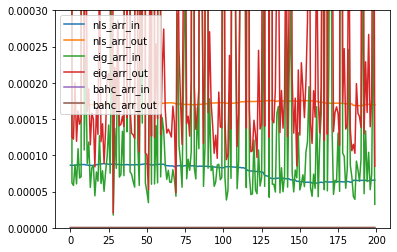

In [31]:
each.iloc[:200][["nls_arr_in", "nls_arr_out", "eig_arr_in", "eig_arr_out", "bahc_arr_in", "bahc_arr_out"]].plot(legend=True, ylim=(0,0.0003))

In [154]:
!pip install --upgrade pandas --user

  Using cached pandas-1.5.3-cp38-cp38-win_amd64.whl (11.0 MB)


In [2]:
pd.__version__

'1.5.3'